# COMS 4701 Summer 2021: Homework 5

**Instructions**: Solve all problems and type up your solutions in this notebook. Each solution should appear in a new cell immediately following the given problem. Written problems should include work and steps in addition to the answers; $\LaTeX$ is highly recommended, but plaintext is also acceptable if it is understandable. You are highly encouraged to read through the accompanying tutorial first if you are new to $\LaTeX$. Coding solutions should be free of errors, and outputs should be left in the notebook for submission.

All submitted work must be your own. Cases of academic dishonesty will be addressed following the policies outlined on the [course syllabus](https://courseworks2.columbia.edu/courses/131236).

In this assignment you will use the [pgmpy](http://pgmpy.org/) library to study Bayesian networks and perform inference on them. The library provides the infrastructure to create or import many well-known networks in the [bnlearn](https://www.bnlearn.com/bnrepository/) repository. Specifically, we will be looking at the ALARM [model](https://www.bnlearn.com/documentation/man/alarm.html), which describes an alarm message system for patient monitoring.

First upload the provided `alarm.bif` file, which is a specialized file format that contains all the necessary information of the Bayesian network. Then run the following cell to locally install pgmpy and import the network.

In [2]:
!pip install pgmpy
from pgmpy.readwrite import BIFReader
reader = BIFReader('alarm.bif')
alarm_model = reader.get_model()
print(alarm_model.nodes())

     |████████████████████████████████| 337kB 5.1MB/s 
['HISTORY', 'CVP', 'PCWP', 'HYPOVOLEMIA', 'LVEDVOLUME', 'LVFAILURE', 'STROKEVOLUME', 'ERRLOWOUTPUT', 'HRBP', 'HREKG', 'ERRCAUTER', 'HRSAT', 'INSUFFANESTH', 'ANAPHYLAXIS', 'TPR', 'EXPCO2', 'KINKEDTUBE', 'MINVOL', 'FIO2', 'PVSAT', 'SAO2', 'PAP', 'PULMEMBOLUS', 'SHUNT', 'INTUBATION', 'PRESS', 'DISCONNECT', 'MINVOLSET', 'VENTMACH', 'VENTTUBE', 'VENTLUNG', 'VENTALV', 'ARTCO2', 'CATECHOL', 'HR', 'CO', 'BP']


You are encouraged, but not required, to use any of the functionalities of pgmpy for the first two problems below. The names of nodes in the network can be seen in the output of the code above. The mappings between these names and their abbreviated versions in the graphic below (as well as their domain values) are explained in the [manual](https://www.bnlearn.com/documentation/man/alarm.html).

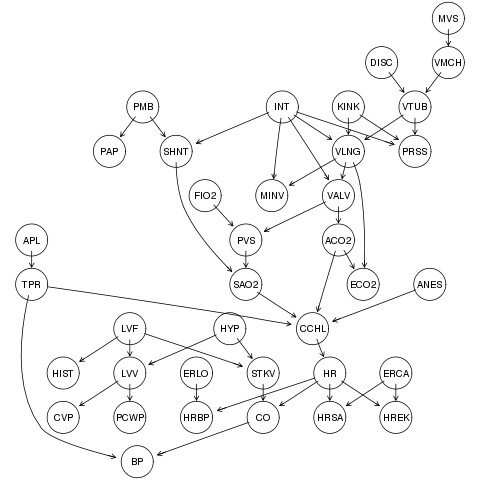

# Problem 1: Independence (20 points)

pgmpy contains several functions for testing independences, which are demonstrated in "Step 4" of this [notebook](https://github.com/pgmpy/pgmpy/blob/dev/examples/Creating%20a%20Discrete%20Bayesian%20Network.ipynb). Again, you have the option of using these functions, though it is not required to do so. Answer the following questions about the independence properties of the alarm network. In your answers, use the abbreviated node names from the graphic. If you write any code, please leave all commands and outputs that you use in the code cell below your responses.

1. Name all variables that are independent of `BP` (at bottom) given no observed evidence in the Bayes net. Briefly explain your answer.
2. List all variable pairs (X, Y) for which "X is conditionally independent of all other variables in the Bayes net, given Y". For example, (MVS, VMCH) is such a pair.
3.  Suppose `CCHL` is observed (to the right and below of the graphic center). Separate all of the nodes of the network (**except for `BP`**) into two groups such that every node in group 1 is conditionally independent of every node in group 2. Instead of writing out two long lists, you may also verbally describe them using graph terminology (e.g., parents, ancestors, descendants), but be sure to be as precise as possible.
4.  Explain why, when `CCHL` is observed, `BP` retains its dependencies to all other nodes except for those you found in part 1. What happens to the conditional independences between the two groups in part 3 if `BP` is now observed in addition to `CCHL`?


ENTER YOUR RESPONSES HERE

1.  Using a combination of common effect and common cause, you can determine that ERCA & BP are independent and ERLO & BP are independent. 

2.  All variable pairs: 
(MVS, VMCH), (PCWP, LVV), (PAP, PMB), (APL, TPR), (HIST, LVF), (CVP, LVV)

3.  Group 1: all descendants of CCHL, LVF and all its descendants, HYP and all its descendants, ERCA and all its descendants, ERLO and all its descendants (all excluding BP) & Group 2: all ancestors of CCHL.

4.  When CCHL is observed, BP still maintains its dependencies with those nodes found in part 1 because BP is connected as a sibling and descendant of CCHL. If BP is observed in addition to CCHL, the two groups loose their conditional independence because TPR and CO would no longer be independent.

In [3]:
# ENTER ANY CODE YOU USE TO HELP ANSWER THE ABOVE QUESTIONS HERE


In addition to its structure, the Bayes net model also specifies the parameters (probabilities). These conditional probability distributions, or CPDs, are stored as tables. Each column corresponds to the CPD of the variable of interest given a combination of its parents' values. 

For example, take the first table in the output below, the CPD for $HR$. The first column is the distribution $\Pr(HR \mid CCHL=normal)$ (which sums to 1). The first row is the "distribution" $\Pr(HR=low \mid CCHL)$ (which does not sum to 1).

The tables in the lower right corner of the network can be accessed as follows (you will be using all these tables in the following problem):

In [4]:
print(alarm_model.get_cpds('HR'))
print("")
print(alarm_model.get_cpds('ERRCAUTER'))
print("")
print(alarm_model.get_cpds('HRSAT'))
print("")
print(alarm_model.get_cpds('HREKG'))

+------------+------------------+----------------+
| CATECHOL   | CATECHOL(NORMAL) | CATECHOL(HIGH) |
+------------+------------------+----------------+
| HR(LOW)    | 0.05             | 0.01           |
+------------+------------------+----------------+
| HR(NORMAL) | 0.9              | 0.09           |
+------------+------------------+----------------+
| HR(HIGH)   | 0.05             | 0.9            |
+------------+------------------+----------------+

+------------------+-----+
| ERRCAUTER(TRUE)  | 0.1 |
+------------------+-----+
| ERRCAUTER(FALSE) | 0.9 |
+------------------+-----+

+---------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+
| ERRCAUTER     | ERRCAUTER(TRUE) | ERRCAUTER(TRUE) | ERRCAUTER(TRUE) | ERRCAUTER(FALSE) | ERRCAUTER(FALSE) | ERRCAUTER(FALSE) |
+---------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+
| HR            |

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Problem 2: Exact Inference (30 points)

For these questions, write the analytical expression for each of the queries in terms of the CPD parameters. Then use the parameters from the model to compute the requested distribution. (Note that pgmpy does contain functionality for performing inference, as shown in Section 4 of this [notebook](https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/2.%20Bayesian%20Networks.ipynb). While you can use this to check your solution, we are looking for the correct analytical expressions used to derive it.)

**Note**: Please be precise with RV notation. Upper-case RVs should only refer to the queried distribution, while lower-case RVs should refer to either observed RVs or dummy RVs being summed over.

1.   Compute the distribution $\Pr(HRSA \mid CCHL = normal)$. For compactness, you can write $\Pr(HRSA \mid cchl)$.
2.   Compute the distribution $\Pr(HRSA \mid CCHL = normal, HREK = normal)$. For compactness, you can write $\Pr(HRSA \mid cchl, hrek)$.
3.   Compute the distribution $\Pr(HR \mid CCHL = normal, HRSA = normal, HREK = normal)$. For compactness, you can write $\Pr(HR \mid cchl, hrsa, hrek)$.

ENTER YOUR SOLUTIONS HERE

1. $$Pr(HRSA | cchl) \propto Pr(HRSA, cchl) = \sum_{erca, hr} Pr(HRSA, cchl, erca, hr)$$
$$ = \sum_{erca, hr} Pr(HRSA|cchl, erca, hr) Pr(hr|cchl, erca) Pr(cchl|erca)Pr(erca)$$ 
$$ = \sum_{erca, hr} Pr(HRSA|erca, hr) Pr(hr|cchl) Pr(erca)$$
$$ = \begin{bmatrix}
0.841\\
0.060\\
0.099
\end{bmatrix}$$

2. $$ Pr(HRSA|cchl, hrek) \propto Pr(HRSA,cchl, hrek) = \sum_{erca, hr} Pr(HRSA, cchl, erca, hr, hrek)$$
$$ = \sum_{erca, hr} Pr(HRSA|cchl, erca, hr, hrek) Pr(hrek|cchl, erca,hr) Pr(hr|cchl, erca) Pr(cchl|erca) Pr(erca)$$ 
$$ = \sum_{erca, hr} Pr(HRSA|erca, hr) Pr(hrek|erca, hr) Pr(hr|cchl)Pr(erca)$$
$$ = \begin{bmatrix}
0.392\\
0.340\\
0.268
\end{bmatrix}$$

3. $$ Pr(HR|cchl, hrsa, hrek) \propto Pr(HR, cchl, hrek, hrsa) = \sum_{erca} Pr(HR|cchl, hrsa, hrek, erca) Pr(hrek|cchl, erca) Pr(hrsa|erca) Pr(erca) $$ \\
 Markov blanket: $Pr(HR|cchl, hrsa, hrek) \propto Pr(HR, hrsa,cchl, hrek) = Pr(HR|CCHL)Pr(CCHL|TPR, SAO2, ACO2, ANES)Pr(HRSA| ERCA, HR)Pr(HREK|HR, ERCA)$ \\
$Pr(HR|cchl, hrsa, hrek) \propto Pr(HR,cchl, hrsa, hrek) = Pr(HR|CCHL)Pr(cchl)Pr(hrsa)Pr(hrek)$ 

# Sampling Algorithms

While exact inference will always get us the right values, the amount of computation increases dramatically for larger Bayesian networks. Approximate inference via sampling is an alternative method. The ```prior_sample``` function below generates a sample for a pgmpy Bayes net in the manner of prior sampling. It samples values one node at a time, assuming that nodes are ordered such that no node occurs before its parents. We also define a ```prob_given_parents``` utility function to interface with the underlying pgmpy CPD structures.

(pgmpy also contains built-in sampling algorithms, but we will not be using them.)

In [6]:
import numpy.random as npr

def prior_sample(model, nodes):
  """
  Generates and returns a single sample as a {variable: value} dictionary
  """
  sample = {}
  for n in nodes:
    cpd = model.get_cpds(n)
    values = (cpd.state_names)[n]
    probs = prob_given_parents(cpd, sample)
    sample[n] = npr.choice(values, p=probs/sum(probs))
  return sample


def prob_given_parents(cpd, sample):
  """
  Returns probability distribution of the node to which cpd corresponds, 
  conditioned on its parents' values in sample
  """
  factors = cpd.variables
  states = cpd.state_names 

  col = 0
  skip = 1
  for i in range(len(factors)-1):
    parent_var = factors[-i-1]
    parent_val = sample[parent_var]
    ind = states[parent_var].index(parent_val)
    col += ind*skip
    skip *= len(states[parent_var])

  return (cpd.get_values())[:,col]  

## Coding 1 (15 points)

Prior sampling does not take into account evidence variables, so we can implement a rejection sampling function that uses ```prior_sample```, followed by a check for consistency with provided evidence. The function below takes in the problem ```model``` and list of ```nodes``` (to be passed into ```prior_sample```), a query variable, the number of samples to attempt, and a dictionary of evidence variables and values. The estimated distribution of the query variable (also a dictionary) and the number of consistent samples generated should then be returned.

In [7]:
def rejection_sample(model, nodes, N, query, evidence={}):
  """
  INPUTS: Problem model, nodes, total number of samples to try (including 
  inconsistent ones), query variable, and a {variable: value} evidence dict
  OUTPUTS: dist, a dictionary providing the estimated distribution for query
           num_consistent, number of consistent samples generated
  """
  dist = {val:0 for val in model.get_cpds(query).state_names[query]}

  # YOUR CODE HERE
  num_consistent = 0
  consistent_check = True
  for i in range(1,N):
    x = prior_sample(model, nodes)
    consistent_check = True
    for key in evidence:
      if x[key] != evidence[key]:
        consistent_check = False
    if consistent_check == True:
      num_consistent = num_consistent + 1
      x_val = x[query]
      dist[x_val] = dist[x_val] + 1
  normalize = sum(dist.values())
  for j, values in dist.items():
    dist[j] = dist[j]/normalize

  return dist, num_consistent
  


In [8]:
NODES = ['MINVOLSET', 'VENTMACH', 'DISCONNECT', 'VENTTUBE', 'KINKEDTUBE', 
         'INTUBATION', 'PULMEMBOLUS', 'PAP', 'SHUNT', 'VENTLUNG', 'PRESS', 
         'FIO2', 'MINVOL', 'VENTALV', 'PVSAT', 'ARTCO2', 'SAO2', 'EXPCO2', 
         'ANAPHYLAXIS', 'TPR', 'INSUFFANESTH', 'CATECHOL', 'LVFAILURE', 
         'HYPOVOLEMIA', 'HISTORY', 'LVEDVOLUME', 'ERRLOWOUTPUT', 'STROKEVOLUME', 
         'HR', 'ERRCAUTER', 'CVP', 'PCWP', 'HRBP', 'CO', 'HRSAT', 'HREKG', 'BP']

dist, num_samples = rejection_sample(alarm_model, NODES, 20000, 'HRSAT', evidence={'CATECHOL': 'NORMAL'})
print("Heart rate and oxygen saturation given that catecholamine is normal: ", dist)
print("Number of consistent samples: ", num_samples)

dist, num_samples = rejection_sample(alarm_model, NODES, 20000, 'HRSAT', evidence={'CATECHOL': 'NORMAL', 'HREKG': 'NORMAL'})
print("Heart rate and oxygen saturation given that catecholamine and EKG monitor signal are normal: ", dist)
print("Number of consistent samples: ", num_samples)

Heart rate and oxygen saturation given that catecholamine is normal:  {'LOW': 0.8450980392156863, 'NORMAL': 0.054901960784313725, 'HIGH': 0.1}
Number of consistent samples:  2040
Heart rate and oxygen saturation given that catecholamine and EKG monitor signal are normal:  {'LOW': 0.4117647058823529, 'NORMAL': 0.3235294117647059, 'HIGH': 0.2647058823529412}
Number of consistent samples:  136


## Response 1 (10 points)

Running the above cell will estimate some of the distributions you computed above by requesting 20000 samples. One query has one evidence variable, while the other has two. 

1.  For the two queries above, which distribution estimate is generally closer to the true distribution? How is this related to the number of consistent samples, and why are these numbers so different for the two queries?

2.  Consider the fraction of consistent samples for each query (that is, number of consistent samples divided by total number of samples requested). What likelihoods do these fractions correspond to from the alarm model?

ENTER YOUR RESPONSES HERE

1. The query with one evidence (the first query) has a distribution estimate that is closer to the true distribution. This is because the first query only has one evidence variable, while the other has two. Generally, we expect the fraction of samples consistent with the evidence to drop exponentially as the number of evidence variables grows. Since the second query has two evidence variabes, the less amount of consistent samples are found. However, the greater number of consistent samples, the closer the distribution estimate is to the true distribution. Thus, since query two has two variables and a smaller amount of consistent samples, the average will vary more. 

2. These fractions correspond to the likelihood of the sample having the provided evidence variable(s). For query one, the fraction corresponds to the likelihood of the sample having 'CATECHOL': 'NORMAL'. For query two, the fraction corresponds to the likelihood of the sample having 'CATECHOL': 'NORMAL', 'HREKG': 'NORMAL'.

## Coding 2 (15 points)

Rejection sampling can end up rejecting a large number of samples, wasting effort. Another sampling method is likelihood weighting, which guarantees that every sample is consistent and associates with each a weight. In the cell below we've partially implemented ```weighted_sample```, which generates a sample consistent with ```evidence```, along with the corresponding weight for that sample.

First complete ```weighted_sample``` to correctly update the weight ```w``` whenever an evidence variable is assigned to a sample.

Then complete ```likelihood_weighting```, which should be very similar to ```rejection_sample``` but without the consistency check. It should compute and return a distribution for ```query``` based on the weights returned by ```weighted_sample```.

In [9]:
def weighted_sample(model, nodes, evidence):
  """
  Generate a sample consistent with evidence, along with corresponding weight
  """
  w = 1
  sample = {}
  for n in nodes:
    cpd = model.get_cpds(n)
    values = (cpd.state_names)[n]
    if n in evidence:
      # YOUR CODE HERE
      sample[n] = evidence[n]
      w = w * prob_given_parents(cpd, sample)[values.index(evidence[n])]
    else:
      probs = prob_given_parents(cpd, sample)
      sample[n] = npr.choice(values, p=probs/sum(probs))
  return sample, w


def likelihood_weighting(model, nodes, N, query, evidence={}):
  """
  INPUTS: Problem model, nodes, query variable, number of samples, 
          and a {variable: value} evidence dict
  OUTPUT: dist, a dictionary providing the estimated distribution for query
  """
  dist = {val:0 for val in model.get_cpds(query).state_names[query]}

  # YOUR CODE HERE
  for i in range(1,N):
    sample, weight = weighted_sample(model, nodes, evidence)
    x_val = sample[query]
    dist[x_val] = dist[x_val] + weight
  normalize = 1.0/sum(dist.values())
  for j, values in dist.items():
    dist[j] = dist[j]*normalize

  return dist


In [11]:
# CHANGE THE NUMBER OF SAMPLES IN THESE QUERIES
dist = likelihood_weighting(alarm_model, NODES, 20000, 'HRSAT', evidence={'CATECHOL': 'NORMAL', 'HREKG': 'NORMAL'})
print("Heart rate and oxygen saturation given that catecholamine and EKG monitor signal are normal: ", dist)

dist = likelihood_weighting(alarm_model, NODES, 20000, 'HR', evidence={'CATECHOL': 'NORMAL', 'HRSAT': 'NORMAL', 'HREKG': 'NORMAL'})
print("Heart rate given that catecholamine, heart rate and saturation, and EKG monitor signal are normal: ", dist)

Heart rate and oxygen saturation given that catecholamine and EKG monitor signal are normal:  {'LOW': 0.4111441488553691, 'NORMAL': 0.3133394840977446, 'HIGH': 0.2755163670468864}
Heart rate given that catecholamine, heart rate and saturation, and EKG monitor signal are normal:  {'LOW': 0.2508346581673759, 'NORMAL': 0.49062012626256074, 'HIGH': 0.25854521557006327}


## Response 2 (10 points)

1.  To estimate the second distribution from Response 1, we again request 20000 samples. However, you can try a smaller number of samples. What is the smallest number of samples to be sufficient for the estimate to be reasonably close (e.g., within about 5%) of the true distribution (show the code output above)? Comment on the efficiency of samples needed for likelihood weighting vs rejection sampling.

2.  Now try running the second query, which corresponds to the third distribution from Problem 2. Use the same number of minmal samples that you used for the first query. Do you find that the distribution estimate is better, worse, or about as accurate as that of the first query? Briefly explain.

ENTER YOUR RESPONSES HERE

1. The smallest number of samples to be sufficient for the estimate to be reasonbly close is 2500. For likelihood weighting, as shown in the weighted_sample function, the algorithm fixes the values for the evidence variables E and samples all the nonevidence variables in topological order, each conditioned on its parents. In likelihood weighting, the specified number of samples are sampled. Conversely, rejection sampling generates samples from the prior distribution specified by the network, and then it rejects all those that do not match the evidence. Thus, not all samples are used. Because likelihood weighting uses all the samples generated, it can be much more efficient that rejection sampling. Likelihood weighting will require less samples to have a distribution close to the true distribution. 

2.  The distribution estimate is about as accurate as that of the first query. Again, this is due to the fact that that, for likelihood weighting, the number of samples is fixed and they are sampling the same number of samples. Recall that likelihood weighting works by sampling the nonevidence nodes of the network in topological order, weighting each sample by the likelihood it accords to the observed evidence variables.